In [1]:
import os
from collections import defaultdict
import random
import pickle
import pandas as pd
import numpy as np

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

In [2]:
# Mount the Google drive for access to files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
endo_dir = '/content/drive/MyDrive/endometriosis/'
annotations_file_path = os.path.join(endo_dir, 'labeling', 'annotated-data', 'formatted-csvs', 'intent.csv')

annotations_df = pd.read_csv(annotations_file_path)

In [5]:
annotations_df = annotations_df[annotations_df["accept"] != "[]"]

In [6]:
annotations_df.shape

(1438, 12)

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [9]:
def get_sent_count(cell_text):
  sentences = sent_tokenize(cell_text)
  sent_num = len(sentences)
  return sent_num

def get_word_count(cell_text):
  words = word_tokenize(cell_text)
  word_num = len(words)
  return word_num

In [10]:
def get_sentence_segments(cell_text, sections = "f_and_l", n = 10):
  sentences = sent_tokenize(cell_text)
  num_sent = len(sentences)

  # if getting first and last
  if sections == "f_and_l":
    if num_sent > n:
      split_n = int(n/2)
      first = sentences[:split_n]
      last = sentences[-split_n:]
      combined_sents = first + last
      combined_sents = " ".join(combined_sents)
    else:
      combined_sents = cell_text

  # if getting first
  elif sections == "f":
    if num_sent > n:
      combined_sents = sentences[0:n]
      combined_sents = " ".join(combined_sents)
    else:
      combined_sents = cell_text

  # if getting last
  elif sections == "l":
    if num_sent > n:
      combined_sents = sentences[-n:]
      combined_sents = " ".join(combined_sents)
    else:
      combined_sents = cell_text

  # if getting middle
  elif sections == "m":
    if num_sent > n:
      middle_index = round(len(sentences)/2)
      half_n = n/2
      first_pos = middle_index - half_n
      last_pos = middle_index + half_n
      combined_sents = sentences[int(first_pos):int(last_pos)]
      combined_sents = " ".join(combined_sents)
    else:
      combined_sents = cell_text

  # if getting random
  elif sections == "r":
    if num_sent > n:
      combined_sents = sample(sentences,n)
      combined_sents = " ".join(combined_sents)
    else:
      combined_sents = cell_text

  elif sections == "all":
    combined_sents = cell_text

  else:
    combined_sents = cell_text

  return combined_sents

In [11]:
annotations_df["num_sents"] = annotations_df["text"].apply(get_sent_count)
annotations_df["num_words"] = annotations_df["text"].apply(get_word_count)

In [12]:
dir_names = ["SEEKING_EXPERIENCES", "SEEKING_INFO", "SEEKING_EMOTION", "SEEKING_EMOTION", "VENT", "PROVIDING_EXPERIENCES", "PROVIDING_INFO", "PROVIDING_EMOTION"]

for dir_name in dir_names:
  # annoying, but there's variation between dir names and our label names
  if dir_name == "SEEKING_EXPERIENCES":
    label_name = "SEEKING EXPERIENCES"

  if dir_name == "SEEKING_INFO":
    label_name = "SEEKING INFORMATIONAL SUPPORT"

  if dir_name == "SEEKING_EMOTION":
    label_name = "SEEKING EMOTIONAL SUPPORT"

  if dir_name == "VENT":
    label_name = "VENT"

  if dir_name == "PROVIDING_EXPERIENCES":
    label_name = "PROVIDING EXPERIENCES"

  if dir_name == "PROVIDING_INFO":
    label_name = "PROVIDING INFORMATIONAL SUPPORT"

  if dir_name == "PROVIDING_EMOTION":
    label_name = "PROVIDING EMOTIONAL SUPPORT"

  model_output_path = os.path.join(endo_dir, 'code', 'output', 'INTENT', 'LR', dir_name)

  # WITH CROSS VAL LOOP
  seeds = [0, 5, 30]
  segments = [8, 10, 12, 16]
  parts = ["f", "f_and_l", "l", "m"]

  for part in parts:
    for num in segments:
      
      zero_precision = []
      zero_recall = []
      zero_f1 = []
      zero_support = []

      one_precision = []
      one_recall = []
      one_f1 = []
      one_support = []

      acc_precision = []
      acc_recall = []
      acc_f1 = []
      acc_support = []

      macro_precision = []
      macro_recall = []
      macro_f1 = []
      macro_support = []

      weighted_precision = []
      weighted_recall = []
      weighted_f1 = []
      weighted_support = []
    
      for seed in seeds:

        test_df = annotations_df
        test_df["shortened_post"] = test_df["text"].apply(get_sentence_segments, sections = part, n = num)

        texts = test_df.shortened_post.tolist()
        vectorizer = TfidfVectorizer(
            max_df = .90,
            min_df = 3
        )
        X = vectorizer.fit_transform(texts)

        y = test_df[label_name].tolist()

        train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = seed)
        
        lr = LogisticRegression()
        model = lr.fit(train_texts, train_labels)
        predicted_labels = model.predict(test_texts)

        class_report = classification_report(predicted_labels, test_labels, output_dict=True)

        zero_precision.append(class_report['0']['precision'])
        zero_recall.append(class_report['0']['recall'])
        zero_f1.append(class_report['0']['f1-score'])
        zero_support.append(class_report['0']['support'])

        one_precision.append(class_report['1']['precision'])
        one_recall.append(class_report['1']['recall'])
        one_f1.append(class_report['1']['f1-score'])
        one_support.append(class_report['1']['support'])

        macro_precision.append(class_report['macro avg']['precision'])
        macro_recall.append(class_report['macro avg']['recall'])
        macro_f1.append(class_report['macro avg']['f1-score'])
        macro_support.append(class_report['macro avg']['support'])

        weighted_precision.append(class_report['weighted avg']['precision'])
        weighted_recall.append(class_report['weighted avg']['recall'])
        weighted_f1.append(class_report['weighted avg']['f1-score'])
        weighted_support.append(class_report['weighted avg']['support'])

      zero_precision_score = sum(zero_precision) / len(zero_precision)
      zero_recall_score = sum(zero_recall) / len(zero_recall)
      zero_f1_score = sum(zero_f1) / len(zero_f1)
      zero_support_score = sum(zero_support) / len(zero_support)

      one_precision_score = sum(one_precision) / len(one_precision)
      one_recall_score = sum(one_recall) / len(one_recall)
      one_f1_score = sum(one_f1) / len(one_f1)
      one_support_score = sum(one_support) / len(one_support)

      macro_precision_score = sum(macro_precision) / len(macro_precision)
      macro_recall_score = sum(macro_recall) / len(macro_recall)
      macro_f1_score = sum(macro_f1) / len(macro_f1)
      macro_support_score = sum(macro_support) / len(macro_support)

      weighted_precision_score = sum(weighted_precision) / len(weighted_precision)
      weighted_recall_score = sum(weighted_recall) / len(weighted_recall)
      weighted_f1_score = sum(weighted_f1) / len(weighted_f1)
      weighted_support_score = sum(weighted_support) / len(weighted_support)

      zero_dict = {'precision': zero_precision_score, 'recall': zero_recall_score, 'f1-score': zero_f1_score, 'support': zero_support_score}
      one_dict = {'precision': one_precision_score, 'recall': one_recall_score, 'f1-score': one_f1_score, 'support': one_support_score}
      macro_dict = {'precision': macro_precision_score, 'recall': macro_recall_score, 'f1-score': macro_f1_score, 'support': macro_support_score}
      weighted_dict = {'precision': weighted_precision_score, 'recall': weighted_recall_score, 'f1-score': weighted_f1_score, 'support': weighted_support_score}

      combined_dict = {'0': zero_dict, '1': one_dict, 'macro avg': macro_dict, 'weighted avg': weighted_dict}

      class_report_df = pd.DataFrame(combined_dict).transpose()
      output_name = 'classification_report_' + part + '_' + str(num) + '_'+ '.csv'
      class_report_df.to_csv(os.path.join(model_output_path, output_name))


  # get overall accuracy
  seeds = [0, 5, 30, 42]

  zero_precision = []
  zero_recall = []
  zero_f1 = []
  zero_support = []

  one_precision = []
  one_recall = []
  one_f1 = []
  one_support = []

  acc_precision = []
  acc_recall = []
  acc_f1 = []
  acc_support = []

  macro_precision = []
  macro_recall = []
  macro_f1 = []
  macro_support = []

  weighted_precision = []
  weighted_recall = []
  weighted_f1 = []
  weighted_support = []

  for seed in seeds:

    texts = annotations_df.text.tolist()
    vectorizer = TfidfVectorizer(
        max_df = .90,
        min_df = 3
    )
    X = vectorizer.fit_transform(texts)

    y = test_df[label_name].tolist()

    train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = seed)
    
    lr = LogisticRegression()
    model = lr.fit(train_texts, train_labels)
    predicted_labels = model.predict(test_texts)

    class_report = classification_report(predicted_labels, test_labels, output_dict=True)

    zero_precision.append(class_report['0']['precision'])
    zero_recall.append(class_report['0']['recall'])
    zero_f1.append(class_report['0']['f1-score'])
    zero_support.append(class_report['0']['support'])

    one_precision.append(class_report['1']['precision'])
    one_recall.append(class_report['1']['recall'])
    one_f1.append(class_report['1']['f1-score'])
    one_support.append(class_report['1']['support'])

    macro_precision.append(class_report['macro avg']['precision'])
    macro_recall.append(class_report['macro avg']['recall'])
    macro_f1.append(class_report['macro avg']['f1-score'])
    macro_support.append(class_report['macro avg']['support'])

    weighted_precision.append(class_report['weighted avg']['precision'])
    weighted_recall.append(class_report['weighted avg']['recall'])
    weighted_f1.append(class_report['weighted avg']['f1-score'])
    weighted_support.append(class_report['weighted avg']['support'])

  zero_precision_score = sum(zero_precision) / len(zero_precision)
  zero_recall_score = sum(zero_recall) / len(zero_recall)
  zero_f1_score = sum(zero_f1) / len(zero_f1)
  zero_support_score = sum(zero_support) / len(zero_support)

  one_precision_score = sum(one_precision) / len(one_precision)
  one_recall_score = sum(one_recall) / len(one_recall)
  one_f1_score = sum(one_f1) / len(one_f1)
  one_support_score = sum(one_support) / len(one_support)

  macro_precision_score = sum(macro_precision) / len(macro_precision)
  macro_recall_score = sum(macro_recall) / len(macro_recall)
  macro_f1_score = sum(macro_f1) / len(macro_f1)
  macro_support_score = sum(macro_support) / len(macro_support)

  weighted_precision_score = sum(weighted_precision) / len(weighted_precision)
  weighted_recall_score = sum(weighted_recall) / len(weighted_recall)
  weighted_f1_score = sum(weighted_f1) / len(weighted_f1)
  weighted_support_score = sum(weighted_support) / len(weighted_support)

  zero_dict = {'precision': zero_precision_score, 'recall': zero_recall_score, 'f1-score': zero_f1_score, 'support': zero_support_score}
  one_dict = {'precision': one_precision_score, 'recall': one_recall_score, 'f1-score': one_f1_score, 'support': one_support_score}
  macro_dict = {'precision': macro_precision_score, 'recall': macro_recall_score, 'f1-score': macro_f1_score, 'support': macro_support_score}
  weighted_dict = {'precision': weighted_precision_score, 'recall': weighted_recall_score, 'f1-score': weighted_f1_score, 'support': weighted_support_score}

  combined_dict = {'0': zero_dict, '1': one_dict, 'macro avg': macro_dict, 'weighted avg': weighted_dict}

  class_report_df = pd.DataFrame(combined_dict).transpose()
  output_name = 'classification_report_all.csv'
  class_report_df.to_csv(os.path.join(model_output_path, output_name))


  # compile all data
  file_names = os.listdir(model_output_path)
  name = "classification_report"

  main_df = pd.DataFrame()
  for name in file_names:
    if 'classification_report' in name:
      temp_df = pd.read_csv(os.path.join(model_output_path, name))
      short_name = '_' + os.path.splitext(name)[0].split('classification_report_')[1]
      temp_df["Unnamed: 0"] = temp_df["Unnamed: 0"].astype(str) + short_name
      main_df = main_df.append(temp_df)


  main_df.to_csv(os.path.join(model_output_path, 'combined_classification_results.csv'))
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

In [13]:
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stopwords = stopwords.words('english')

remove_from_stops = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves','he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']

stopwords_best = [token for token in stopwords if token not in remove_from_stops]
print(stopwords_best)

import string
exclude = set(string.punctuation)
from sklearn.feature_extraction.text import CountVectorizer as CV

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    return_string = ''.join([char for char in in_string if ord(char) < 128 and char not in exclude]).lower()
    return_string = ' '.join([word for word in return_string.split() if word not in stopwords_best])
    return return_string

def bayes_compare_language(l1, l2, output_path, ngram=1, prior=.01, cv=None, sig_val=2.573):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]

    if cv is None:
        cv = CV(
            decode_error = 'ignore', 
            min_df = 10, 
            max_df = .9, 
            ngram_range=(1,ngram),
            binary = False,
            max_features = 1500)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v: k for k, v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = [(index_to_term[i], z_scores[i]) for i in sorted_indices]
    

    # plotting z scores and frequencies
    x_vals = count_matrix.sum(axis=0)
    y_vals = z_scores
    sizes = abs(z_scores) * 2
    neg_color, pos_color, insig_color = ('#340509', '#053430', '#d8d8d8')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(pos_color)
            annots.append(index_to_term[i])
        elif y < -sig_val:
            colors.append(neg_color)
            annots.append(index_to_term[i])
        else:
            colors.append(insig_color)
            annots.append(None)

    
    fig, ax = plt.subplots(figsize=(14,20))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0, alpha = 0.4)

    for i, annot in enumerate(annots):
        if annot is not None:
            if (np.abs(y_vals[i]) > 2.573):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', fontsize=12)

    ax.set_xscale('log')
    plt.xlabel("Word Frequency")
    plt.ylabel("z-score (log scale)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(output_path, 'fightin_words.png'), dpi = 300)

    return return_list, cv.vocabulary_

['it', "it's", 'its', 'itself', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 

In [14]:
vent_list = annotations_df[annotations_df["VENT"] == 1].text.tolist()
non_vent_list = annotations_df[annotations_df["VENT"] == 0].text.tolist()


Vocab size is 1500
Comparing language...


,0,1
0,ive,-17.414391
1,endo,-17.153351
2,me,-15.444363
3,anyone,-14.653167
4,you,-14.272056
5,surgery,-13.825785
6,period,-13.300406
7,like,-12.621214
8,get,-12.445843
9,they,-11.934442


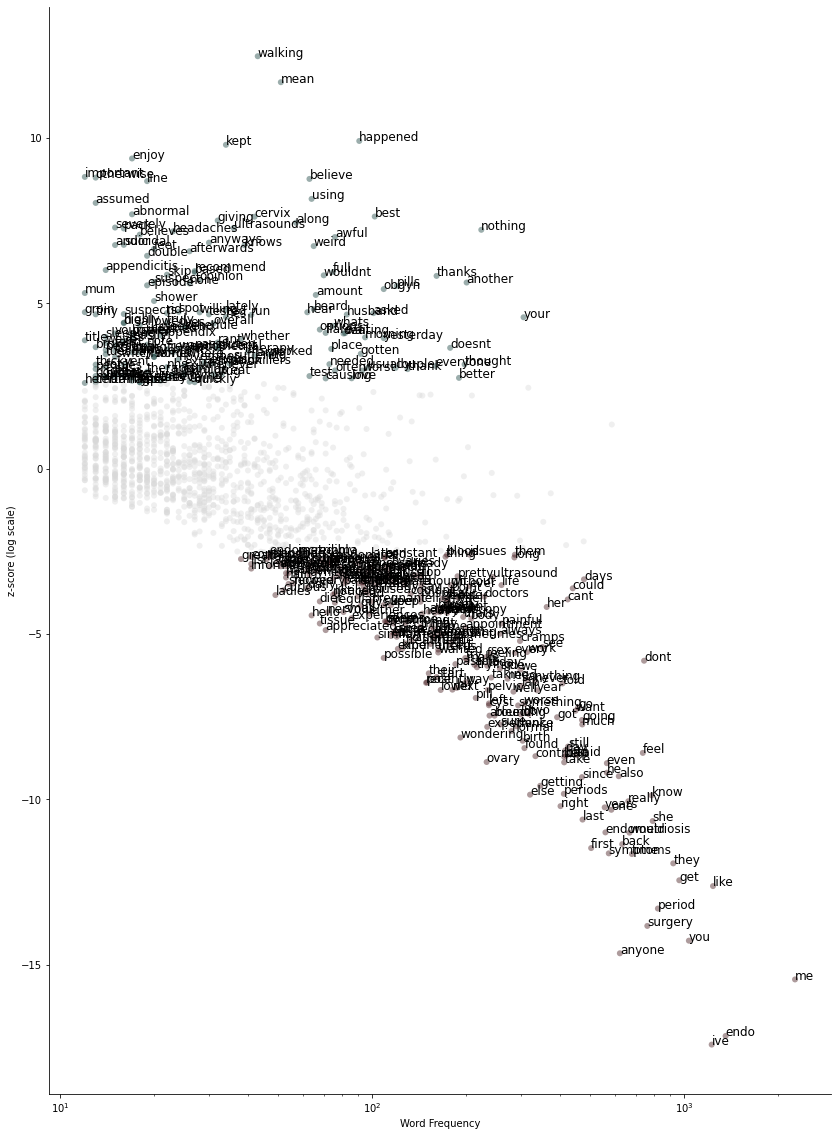

In [15]:
# setting max df very low, given that a document is a sentence
vectorizer = CV(decode_error = 'ignore', max_df = .60, min_df = 3, binary = False, max_features = 1500)  

vector = vectorizer.fit_transform(vent_list + non_vent_list)

vector_prior = np.sum(vector, axis=0).astype(int)

vector_prior = np.squeeze(np.asarray(vector_prior))

output_list, vocabulary = bayes_compare_language(vent_list, non_vent_list, model_output_path, prior=vector_prior, cv=vectorizer)
z_scores_df = pd.DataFrame(output_list)

z_scores_df.head(50)

In [16]:
z_scores_df.tail(50)

,0,1
1450,lately,4.806478
1451,heard,4.826038
1452,shower,5.071667
1453,amount,5.254503
1454,mum,5.312504
1455,obgyn,5.431603
1456,pills,5.530382
1457,episode,5.545388
1458,none,5.602499
1459,another,5.629321
